In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import files
uploaded=files.upload()

Saving TSLA.csv to TSLA.csv


In [478]:
df=pd.read_csv("TSLA.csv")

In [479]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [480]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [481]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


In [483]:
df["Date"]=pd.to_datetime(df["Date"])

In [485]:
tesla_data=df[["Date","Close"]]

In [486]:
print("Min. Tarih:",tesla_data["Date"].min())
print("Max. Tarih:",tesla_data["Date"].max())

Min. Tarih: 2010-06-29 00:00:00
Max. Tarih: 2020-02-03 00:00:00


In [487]:
tesla_data.index=tesla_data["Date"]
tesla_data

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


In [488]:
tesla_data.drop("Date",axis=1,inplace=True)
tesla_data

<ipython-input-488-e7f49f48d508>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_data.drop("Date",axis=1,inplace=True)


,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


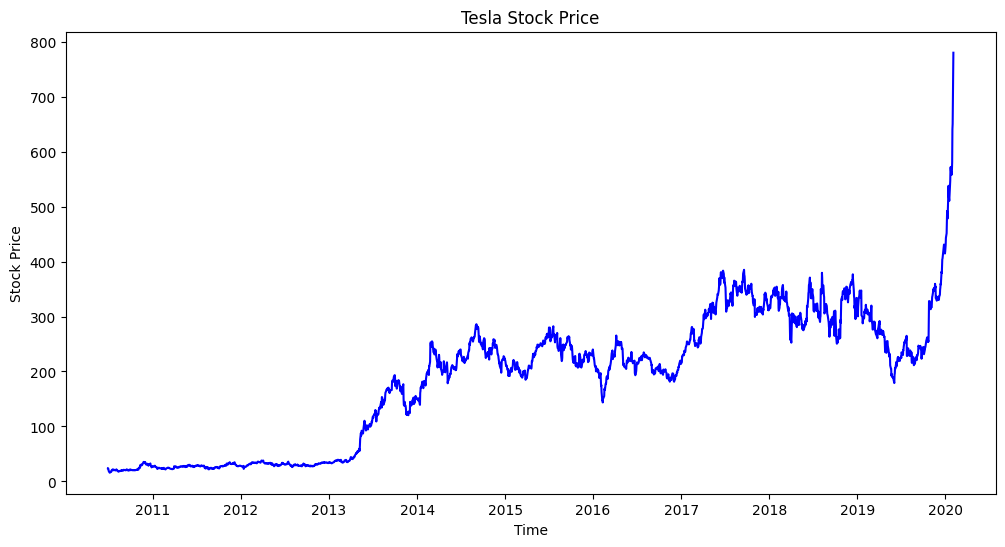

In [489]:
plt.figure(figsize=(12,6))
plt.plot(tesla_data["Close"],color="blue");
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price")
plt.xlabel("Time")
plt.show()

In [490]:
tesla_data=tesla_data.values
tesla_data[0:5]


array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [491]:
tesla_data=tesla_data.astype("float32")

In [492]:
def split_data(dataframe,test_size):
    pos=int(round(len(dataframe)*(1-test_size)))
    train=dataframe[:pos]
    test=dataframe[pos:]
    return train,test,pos
train,test,pos=split_data(tesla_data,0.20)
print(train.shape,test.shape)

(1933, 1) (483, 1)


In [493]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [494]:
def create_features(data,lookback):
    X,Y=[],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)
lookback=20

In [495]:

X_train,y_train=create_features(train,lookback)
X_test,y_test=create_features(test,lookback)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [496]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


In [497]:
model=Sequential()
model.add(LSTM(units=50,
              activation="relu",
              input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 50)             │        14,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

In [498]:
model.compile(loss="mean_squared_error",optimizer="adam")
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),
          ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",
                         save_best_only=True,save_weights_only=False,verbose=1)]
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
85/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 1: val_loss improved from inf to 0.00414, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 2/100
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 2: val_loss improved from 0.00414 to 0.00333, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 3/100
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 3: val_loss improved from 0.00333 to 0.00299, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 4/100
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 4: val_loss improved from 0.00299 to 0.00271, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 5/100
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 5: val_loss improved from 0.00271 to 0.00250, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 6/100
82/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 6: val_loss improved from 0.00250 to 0.00249, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 7/100
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013    
Epoch 7: val_loss improved from 0.00249 to 0.00228, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 8/100
84/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011    
Epoch 8: val_loss improved from 0.00228 to 0.00207, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 9: val_loss improved from 0.00207 to 0.00201, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 10/100
83/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012    
Epoch 10: val_loss improved from 0.00201 to 0.00184, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 11/100
86/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011    
Epoch 11: val_loss did not improve from 0.00184
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 12/100
80/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010    
Epoch 12: val_loss improved from 0.00184 to 0.00175, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 13/100
83/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011    
Epoch 13: val_loss did not improve from 0.00175
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 14/100
86/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013    
Epoch 14: val_loss did not improve from 0.00175
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 15/100
83/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 15: val_loss did not improve from 0.00175
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 15: early stopping


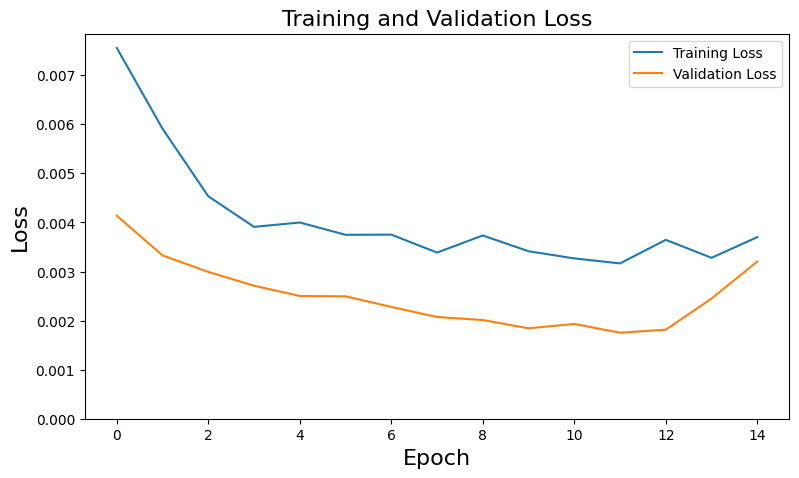

In [499]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

In [500]:
loss=model.evaluate(X_test,y_test,batch_size=20)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 


In [501]:
print("\nTest loss:%.1f%%"%(100.0*loss))


Test loss:0.3%


In [502]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [503]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict,))
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:15.277630398742664
Test RMSE:34.01371398800508


In [504]:
train_prediction_data = pd.DataFrame(tesla_df[lookback:int(round(len(df)*(1-0.2)))])
train_prediction_data["Predicted"] = train_predict
train_prediction_data.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,38.168980
2010-07-29,20.350000,38.252056
2010-07-30,19.940001,38.223186
2010-08-02,20.920000,38.137032
2010-08-03,21.950001,38.123856


In [505]:
test_prediction_data=pd.DataFrame(tesla_df[int(round(len(df)*(1-0.2)))+lookback:])
test_prediction_data["Predicted"]=test_predict
test_prediction_data.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,324.008331
2018-04-04,286.940002,320.853210
2018-04-05,305.720001,320.055328
2018-04-06,299.299988,323.206177
2018-04-09,289.660004,323.738251


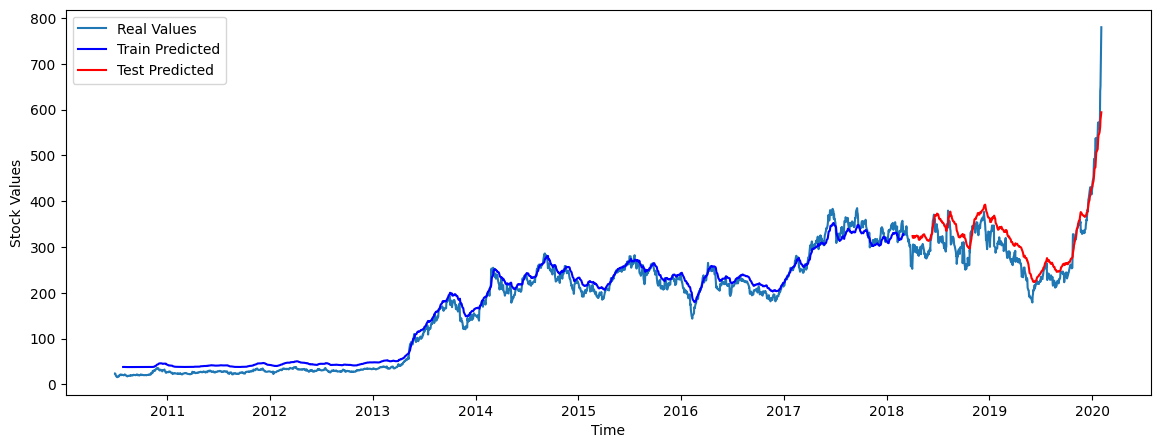

In [506]:
plt.figure(figsize=(14,5))
plt.plot(tesla_df,label="Real Values")
plt.plot(train_prediction_data["Predicted"],color="blue",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()